## PyMC

In [3]:
import pymc3 as pm
import numpy as np
import pylab as plt

In [86]:
obs = np.array([0.8,0.8,0.8])
obs = np.reshape(obs, (-1,1))
obs.shape

(3, 1)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [b]
>Metropolis: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The number of effective samples is smaller than 25% for some parameters.


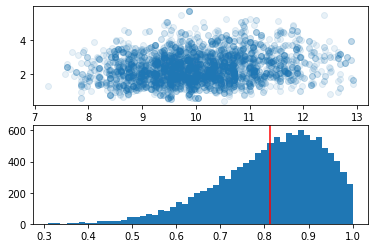

In [87]:
with pm.Model() as model:
    a = pm.Gamma('a', mu = 10, sigma = 1)
    b = pm.Gamma('b', mu = 1, sigma = 1)
    ll = pm.Beta('obs', a ,b, observed = obs)
    
    trace = pm.sample(step=pm.Metropolis())
    
    ppc = pm.sample_posterior_predictive(trace)
    
fig,ax = plt.subplots(2,1)
ax[0].scatter(trace['a'], trace['b'], alpha = 0.1)
ax[1].hist(ppc['obs'].flatten(), bins = 50);
ax[1].axvline(ppc['obs'].flatten().mean(), color = 'red')

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [b]
>Metropolis: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The number of effective samples is smaller than 25% for some parameters.


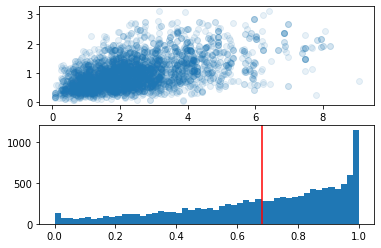

In [88]:
with pm.Model() as model:
    a = pm.Gamma('a', mu = 1, sigma = 1)
    b = pm.Gamma('b', mu = 1, sigma = 1)
    ll = pm.Beta('obs', a ,b, observed = obs)
    
    trace = pm.sample(step=pm.Metropolis())
    
    ppc = pm.sample_posterior_predictive(trace)
    
fig,ax = plt.subplots(2,1)
ax[0].scatter(trace['a'], trace['b'], alpha = 0.1)
ax[1].hist(ppc['obs'].flatten(), bins = 50);
ax[1].axvline(ppc['obs'].flatten().mean(), color = 'red')

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [b]
>Metropolis: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The number of effective samples is smaller than 25% for some parameters.


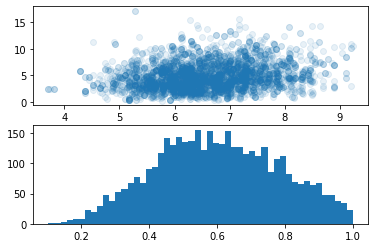

In [75]:
obs = [0.1]
with pm.Model() as model:
    a = pm.Gamma('a', mu = 8, sigma = 1)
    b = pm.Gamma('b', mu = 1, sigma = 1)
    ll = pm.Beta('obs', a ,b, observed = obs)
    
    trace = pm.sample(step=pm.Metropolis())
    
    ppc = pm.sample_posterior_predictive(trace)
    
fig,ax = plt.subplots(2,1)
ax[0].scatter(trace['a'], trace['b'], alpha = 0.1)
ax[1].hist(ppc['obs'], bins = 50);

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [b]
>Metropolis: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The number of effective samples is smaller than 25% for some parameters.


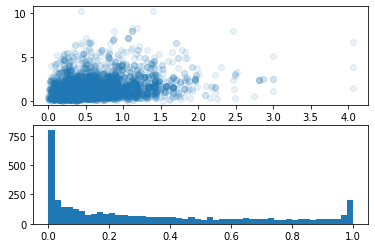

In [76]:
obs = [0.1]
with pm.Model() as model:
    a = pm.Gamma('a', mu = 1, sigma = 1)
    b = pm.Gamma('b', mu = 1, sigma = 1)
    ll = pm.Beta('obs', a ,b, observed = obs)
    
    trace = pm.sample(step=pm.Metropolis())
    
    ppc = pm.sample_posterior_predictive(trace)
    
fig,ax = plt.subplots(2,1)
ax[0].scatter(trace['a'], trace['b'], alpha = 0.1)
ax[1].hist(ppc['obs'], bins = 50);

In [153]:
with pm.Model() as d_mod:
    d = pm.Dirichlet('d',[2,2,2])
    trace = pm.sample(step=pm.Metropolis())

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [d]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The number of effective samples is smaller than 10% for some parameters.


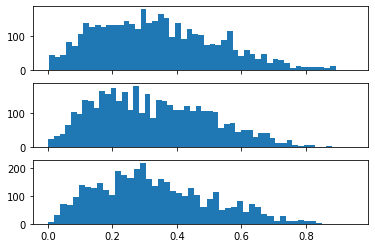

In [154]:
fig, ax = plt.subplots(3, sharex=True)
for this_ax, this_dat in zip(ax, trace['d'].T):
    this_ax.hist(this_dat, bins = 50)

## Scipy

In [132]:
class normalized_dist():
    def __init__(self,prior_dist):
        self.dist = prior_dist
        
    def mult(self,new_dist):
        new_dist = new_dist / new_dist.sum()
        temp_dist = self.dist * new_dist
        temp_dist = temp_dist / temp_dist.sum()
        self.dist = temp_dist
        return self
    def bulk_mult(self, dist_list):
        for this_dist in dist_list:
            self = self.mult(this_dist)
        return self

In [26]:
from scipy.stats import beta

In [91]:
x = np.linspace(0,1,100)
dt = np.diff(x).mean()
prior_params = [1,1]
pos1_params = [8,1]
neg1_params = [1,8]

In [106]:
prior = beta.pdf(x,*prior_params)
prior = prior / prior.sum()
pos1 = beta.pdf(x,*pos1_params)
pos1 = pos1/pos1.sum()
neg1 = beta.pdf(x,*neg1_params)
neg1 = neg1/neg1.sum()

In [147]:
prior_pos_neg = normalized_dist(prior).bulk_mult([neg1,pos1])
prior_pos2_neg2 = normalized_dist(prior).bulk_mult([neg1,neg1,pos1,pos1])
prior_pos2_neg4 = normalized_dist(prior).bulk_mult([neg1,neg1,neg1,neg1,pos1,pos1])

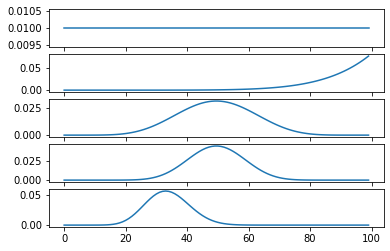

In [148]:
fig,ax = plt.subplots(5,1, sharex=True)
ax[0].plot(prior)
ax[1].plot(pos1)
ax[2].plot(prior_pos_neg.dist)
ax[3].plot(prior_pos2_neg2.dist)
ax[4].plot(prior_pos2_neg4.dist)

## Truncated counts

In [277]:
class prob_dist():
    """
    The truncation can be understood as a finite history approximation.
    Neural networks can't keep track of arbitrary history durations
    as would be expected from pure bayesian updating.
    """
    def __init__(self, prior):
        self.dist = prior
        
    def add(self, dim_ind, result):
        """
        Assuming only single magnitude exposures
        """
        # Add count to requested dim
        self.dist[dim_ind][result] += 1
        # Subtract counts from other dims
        dim_list = np.arange(len(self.dist))
        other_dims = np.delete(dim_list, dim_ind)
        if len(other_dims) > 1:
            dim_choice = np.random.choice(other_dims,1)[0]
        else:
            dim_choice = other_dims[0]
        result_choice = np.random.choice(['h','t'],1)[0]
        self.dist[dim_choice][result_choice] -= 1
        if self.dist[dim_choice][result_choice] <= 1:
            self.dist[dim_choice][result_choice] = 1
        
    def return_probs(self):
        x = np.linspace(0,1,100)
        y = np.stack([beta.pdf(x, this_dist['h'], this_dist['t']) \
                     for this_dist in self.dist])
        return x,y

Text(0.5, 1.0, "[{'h': 1764, 't': 236}, {'h': 249, 't': 1751}]")

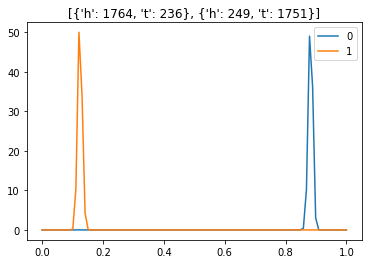

In [278]:
dims = 2
prior_counts = 1000
prior = [dict(h = prior_counts, t = prior_counts) for i in range(dims)]
dist = prob_dist(prior)
for _ in range(1500):
    dist.add(0,'h')
for _ in range(1500):
    dist.add(1,'t')
    
x,y = dist.return_probs()
for y_num, this_y in enumerate(y):
    plt.plot(x,this_y, label = y_num)
plt.legend()
plt.title(dist.dist)

Text(0.5, 1.0, "[{'h': 251, 't': 249}, {'h': 1000, 't': 2500}]")

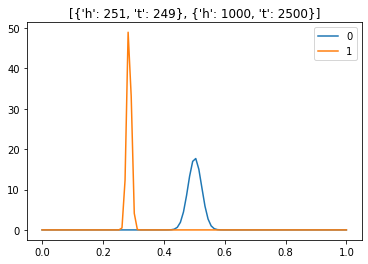

In [279]:
dims = 2
prior_counts = 1000
prior = [dict(h = prior_counts, t = prior_counts) for i in range(dims)]
dist = prob_dist(prior)
for _ in range(1500):
    dist.add(1,'t')
    
x,y = dist.return_probs()
for y_num, this_y in enumerate(y):
    plt.plot(x,this_y, label = y_num)
plt.legend()
plt.title(dist.dist)

Text(0.5, 1.0, "[{'h': 2500, 't': 2500}, {'h': 1, 't': 1}]")

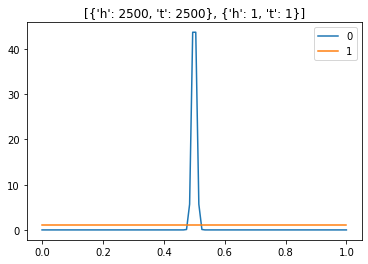

In [280]:
dims = 2
prior_counts = 1000
prior = [dict(h = prior_counts, t = prior_counts) for i in range(dims)]
dist = prob_dist(prior)
for _ in range(1500):
    dist.add(0,'h')
for _ in range(1500):
    dist.add(0,'t')
    
x,y = dist.return_probs()
for y_num, this_y in enumerate(y):
    plt.plot(x,this_y, label = y_num)
plt.legend()
plt.title(dist.dist)

## Questions
1) Saturation of exposures, that is, at some point, exposure to new stimuli shouldn't have an effect <br>
2) This model doesn't care whether you give multiple tastants or one tastant multiple times (perhaps a 'per-taste' saturation needs to be added) <br>
3) Can we interpret width of distribution here? If it is indeed uncertainty, then animal should be willing to explore for more uncertain tastes. As such, if an animal has a lot of positive AND negative counts, variance will go down and it should no longer explore for that taste.